In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from lsda.mcs import *
from lsda.nn import *
from lsda.score import *
from lsda.utils import *
from lsda import model

import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import yaml
from pathlib import Path

root_dir = Path('..')

### Evaluation

In [3]:
# Load testing data
size = (120, 240)
test_years = np.arange(2021, 2023)
testset = ERA5Dataset(years=test_years, size=size, window=64, flatten=False)

/burg/home/jn2808/.conda/envs/bench/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [4]:
# Load saved model
sda = load_model_from_checkpoint(model_name = 'sda_0', version_num=0)

Generate low frequency observations for assimilation (in latent space)

In [5]:
def coarsen(x: Tensor, r: int = 2) -> Tensor:
    *batch, h, w = x.shape

    x = x.reshape(*batch, h // r, r, w // r, r)
    x = x.mean(dim=(-3, -1))

    return x

def upsample(x: Tensor, r: int = 2, mode: str = 'bilinear') -> Tensor:
    *batch, h, w = x.shape

    x = x.reshape(-1, 1, h, w)
    x = torch.nn.functional.pad(x, pad=(1, 1, 1, 1), mode='circular')
    x = torch.nn.functional.interpolate(x, scale_factor=(r, r), mode=mode)
    x = x[..., r:-r, r:-r]
    x = x.reshape(*batch, r * h, r * w)

    return x

In [6]:
# Process label data
test_x, _ = testset[0]
true_x = test_x[:29]

In [10]:
# Process coarsen data
def A(x):
    return coarsen(x[..., ::4, :, :, :], 8)

sigma_sq = 0.1
y_star = torch.normal(A(true_x), sigma_sq)

# For plotting
w_true = true_x[::4]
w_coarse = upsample(y_star, 2, mode='nearest')

In [11]:
n_corrections = 1
n_steps = 512
tau = 0.5
all_x_sample = []

# Sampling for diffusion model
sde_eval = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=sigma_sq,
        sde=VPSDE(sda.score, shape=()),
    ),
    shape=true_x.shape).to(device)

x = sde_eval.sample(steps=n_steps, corrections=n_corrections, tau=tau)
x = x[::4]
all_x_sample.append(x)

# Combine all samples
all_x_sample = torch.stack(all_x_sample)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [11:28<00:00,  1.34s/it]


### Plotting: SDA

wasserstein distance: 0.008276272032666942


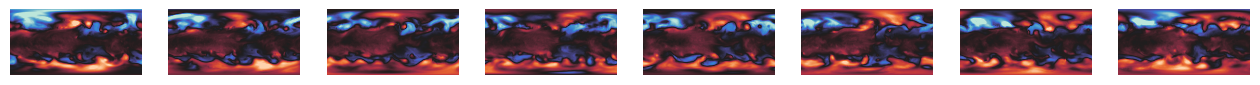

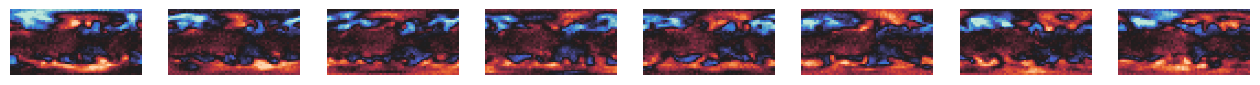

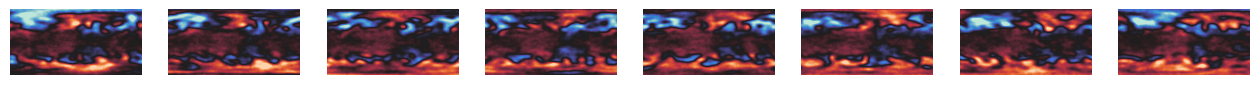

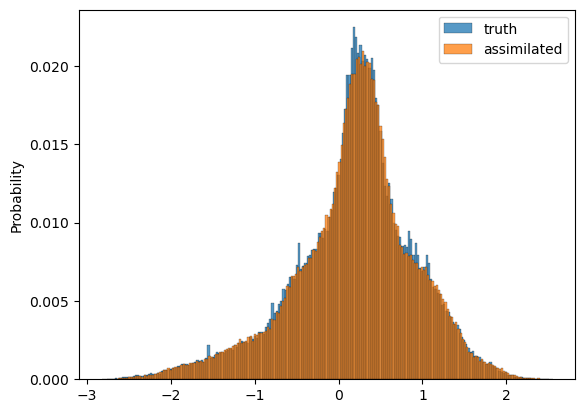

In [9]:
# 4x coarsening
plot_assimilation_results(w_true, w_coarse, all_x_sample, param_idx=3)
wasserstein_d = plot_and_compute_distributions(w_true, all_x_sample, param_idx=3)
print(f'wasserstein distance: {wasserstein_d}')

wasserstein distance: 0.03998869723398883


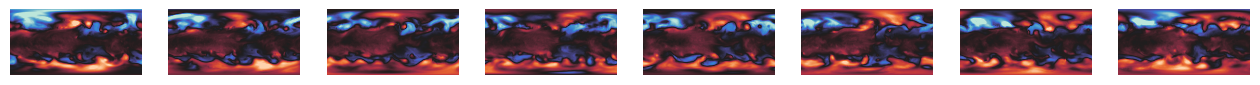

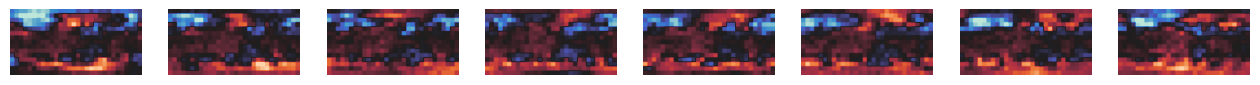

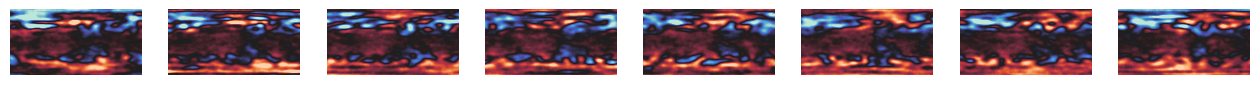

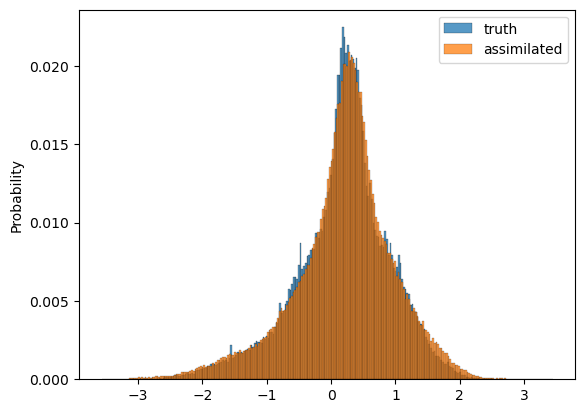

In [12]:
# 8x coarsening
plot_assimilation_results(w_true, w_coarse, all_x_sample, param_idx=3)
wasserstein_d = plot_and_compute_distributions(w_true, all_x_sample, param_idx=3)
print(f'wasserstein distance: {wasserstein_d}')

wasserstein distance: 0.7020476296688828


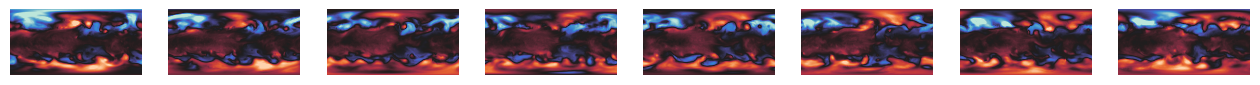

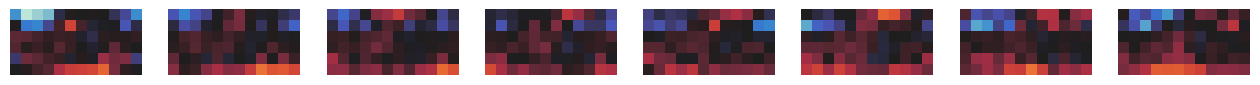

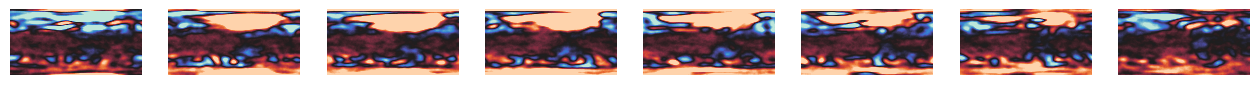

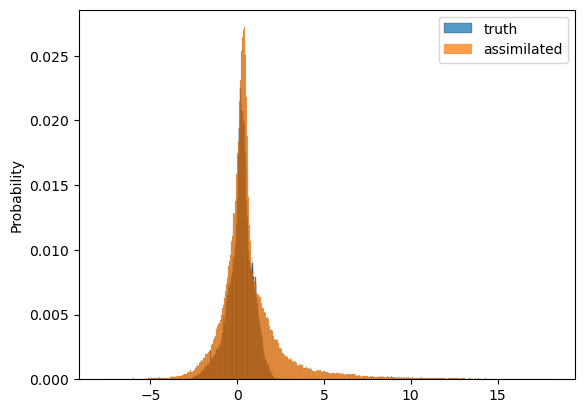

In [15]:
# 20x coarsening
plot_assimilation_results(w_true, w_coarse, all_x_sample, param_idx=3)
wasserstein_d = plot_and_compute_distributions(w_true, all_x_sample, param_idx=3)
print(f'wasserstein distance: {wasserstein_d}')